
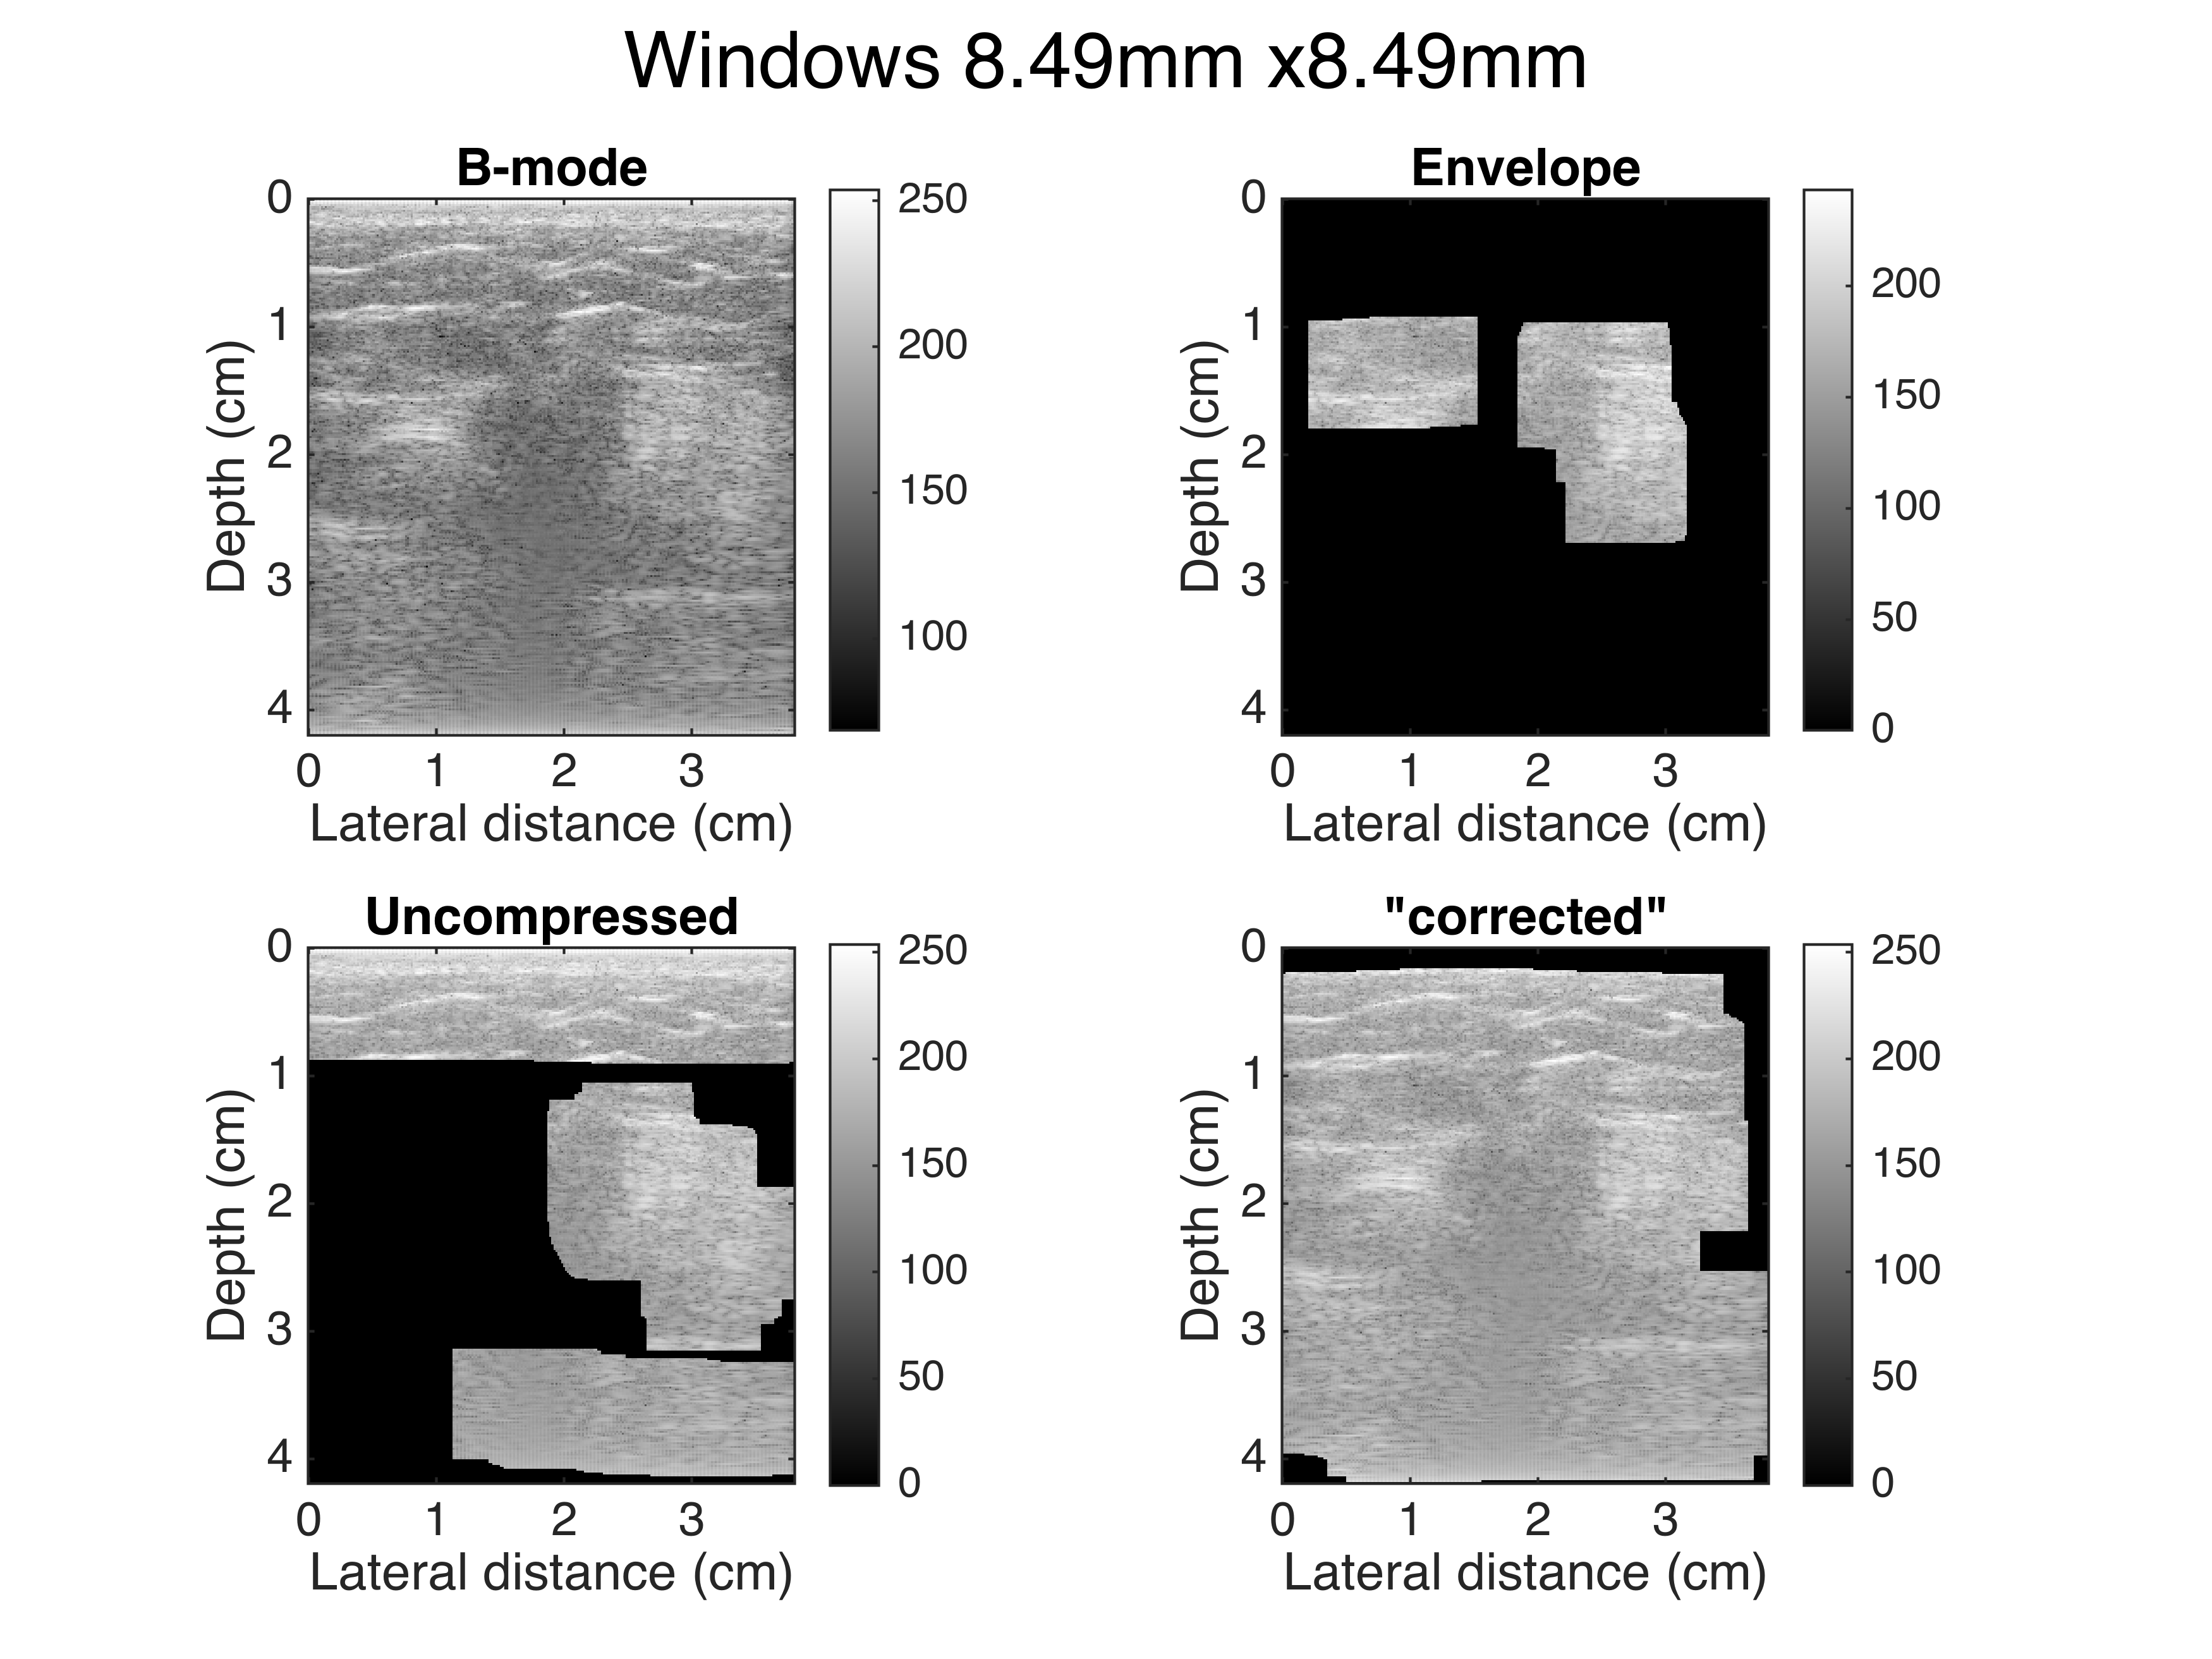

breast:1/514(1) : 361.2694s
Ground truth coeff: 20.2499
Envelope:
Junto   : 24.5507 (+21.239%%)
Separado: 22.0271 (+8.7761%%)
Uncompressed:
Junto1  : 32.8868 (+62.405%%)
Junto2  : 23.8958 (+18.004%%)
Separado: 19.7303 (-2.5663%%)
Corrected:
Junto   : 29.2926 (+44.655%%)
Separado: 20.6681 (+2.0652%%)


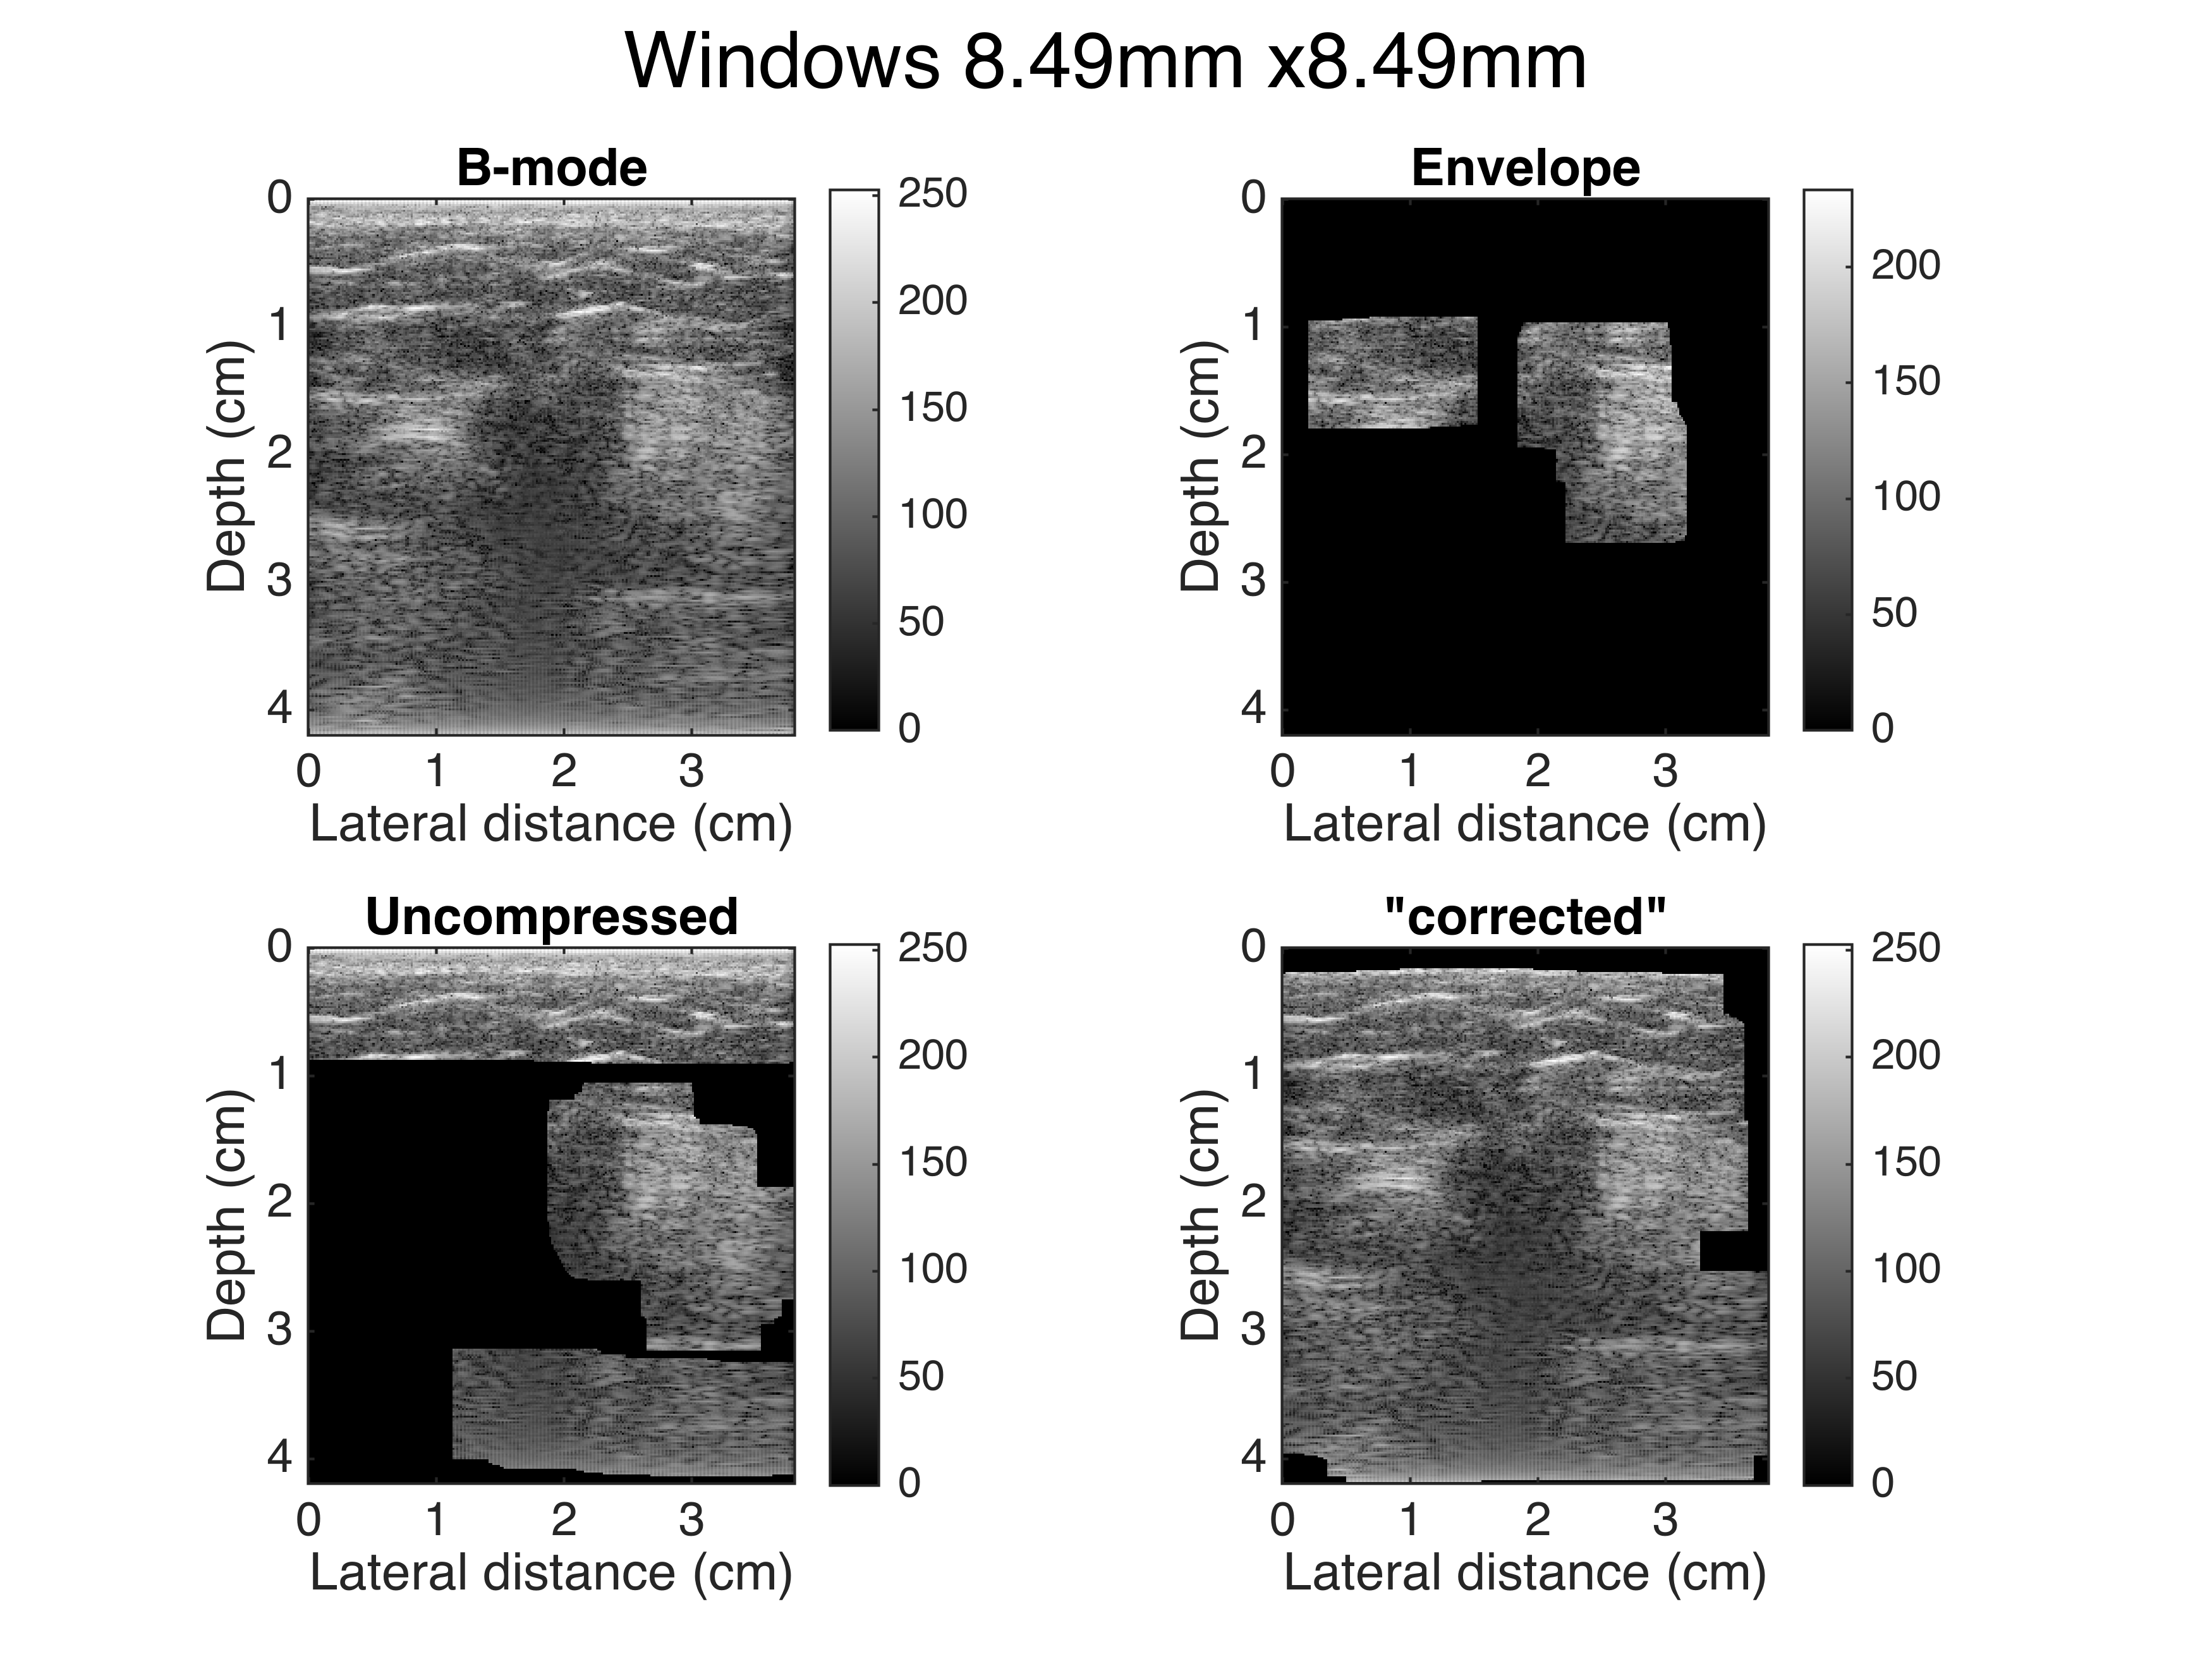

breast:1/514(2) : 358.6076s
Ground truth coeff: 37.2465
Envelope:
Junto   : 45.0711 (+21.007%%)
Separado: 40.5142 (+8.7732%%)
Uncompressed:
Junto1  : 60.4254 (+62.231%%)
Junto2  : 43.8895 (+17.835%%)
Separado: 36.2917 (-2.5634%%)
Corrected:
Junto   : 53.8114 (+44.474%%)
Separado: 38.0125 (+2.0567%%)


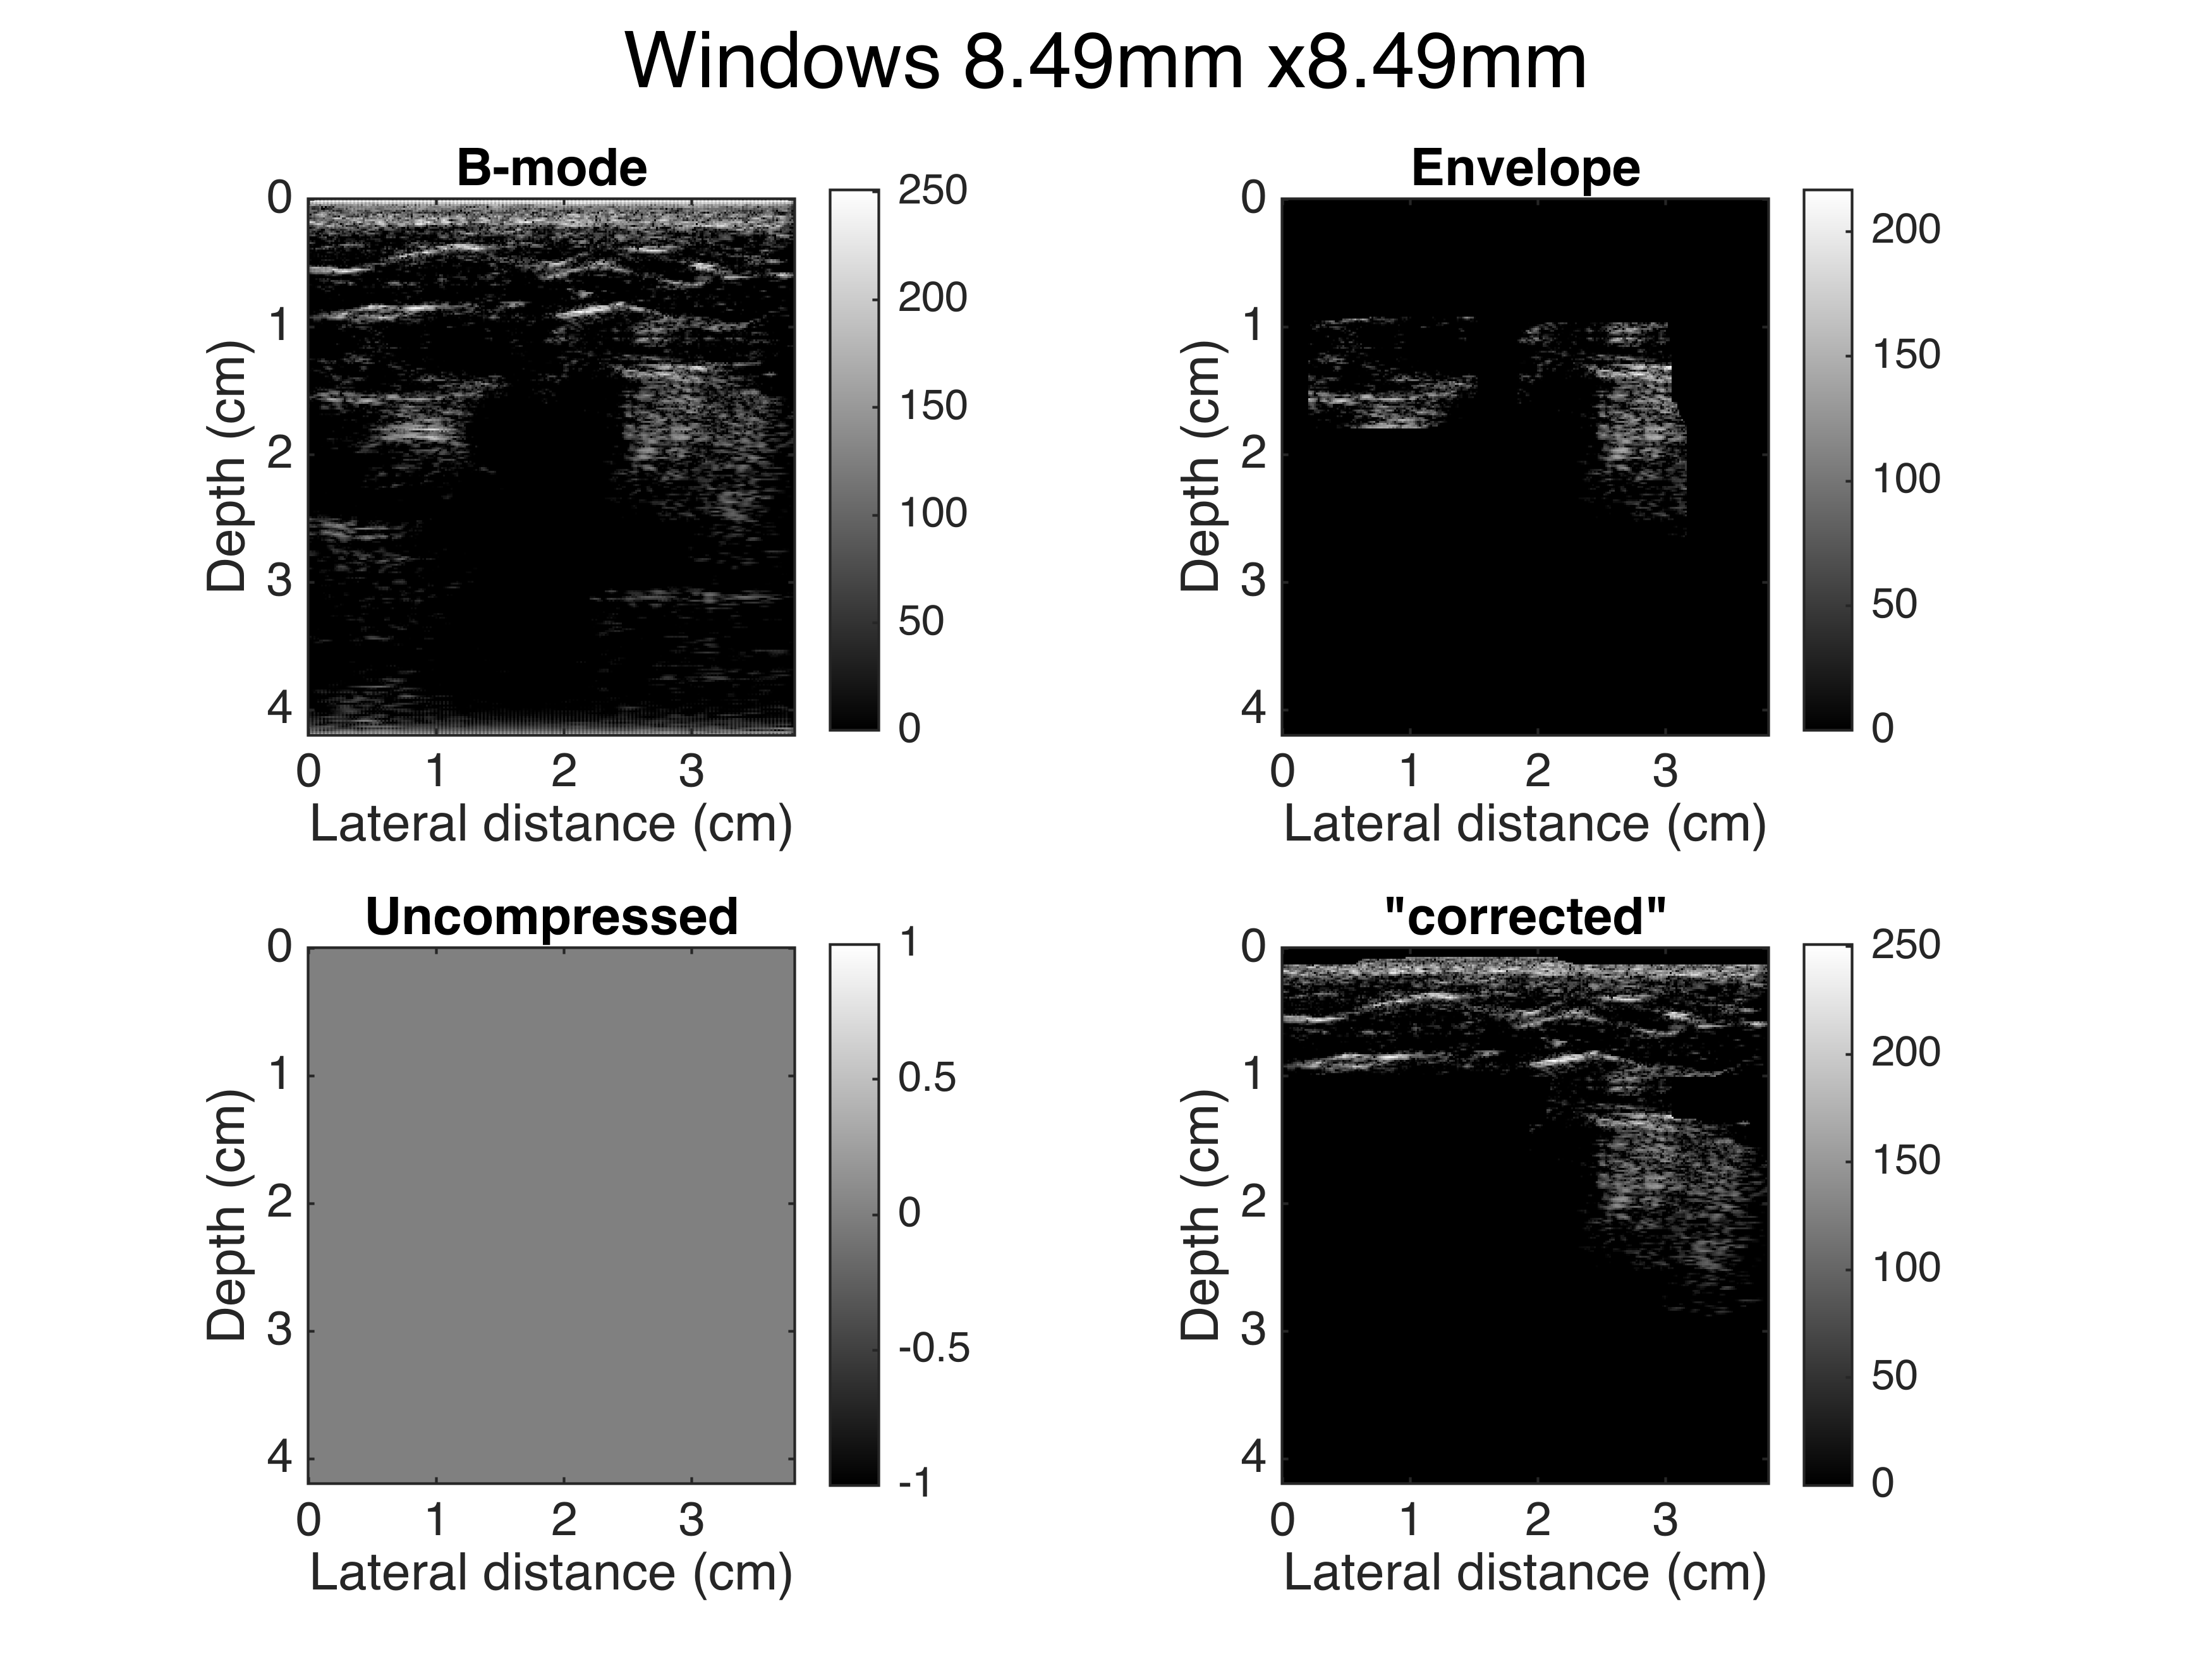

breast:1/514(3) : 268.2655s
Ground truth coeff: 66.0232
Envelope:
Junto   : 57.9342 (-12.252%%)
Separado: 62.2086 (-5.7777%%)
Uncompressed:
Error using lsqncommon (line 38)
Objective function is returning Inf or NaN values at initial point. lsqnonlin cannot continue.
Error in lsqnonlin (line 264)
    lsqncommon(funfcn,xCurrent,lb,ub,options,defaultopt,caller,...
Error in est_prager (line 22)
D_prager = lsqnonlin(@(D) optimizarD(D, z, nmom_exp, n), D0,[],[],optimoptions('lsqnonlin','Display','none'));

In [1]:
close all;clear;clc;
addpath('../../code/functions/');

fcell={'breast\','ganglio\'};

% for kcell=1:length(fcell)
for kcell=1
f=fcell{kcell};
lstfiles=ls([f,'*.rf']);
tot=size(lstfiles,1);

% for i=1:tot
% for i=[1 3]
for i=[1]
    fname=strtrim(lstfiles(i,:));
    [rf,feat] = RPread([f,fname]);
    env_rf=abs(hilbert(rf));

    z=(1540/(2*feat.sf))*feat.h;
    x=0.038;
    z=linspace(0,z,size(rf,1));
    x=linspace(0,x,size(rf,2));
    feat.z=z;
    feat.x=x;

    res=x(2)-x(1);
    z_interp=z(1):res:z(end);
    feat.z_interp=z_interp;

    [X,Z]=meshgrid(x,z);
    [X_interp,Z_interp]=meshgrid(x,z_interp);

for j=1:5
    [a_0,b_0,comp_env]=getab(env_rf,j);
    % comp_env=20*log10(env_rf/max(env_rf(:)));

    comp_env_interp = interp2(X,Z,comp_env,X_interp,Z_interp);
    env_rf_interp = interp2(X,Z,env_rf,X_interp,Z_interp);

    comp_env_interp(comp_env_interp<0) = 0;

    [rows, cols] = size(env_rf_interp);
    n=57;
    m=n;

    % Preallocate output matrix
    output_rows = rows - n + 1;
    output_cols = cols - m + 1;

    % metrics
    k_matrix = zeros(output_rows, output_cols);
    beta_matrix = zeros(output_rows, output_cols);
    validRS = zeros(size(k_matrix));
    validRS_uncomp = zeros(size(k_matrix));
    validRS_uncomp_corr = zeros(size(k_matrix));
    a_matrix_valid=[];
    a_matrix_valid_uncomp=[];
    a_matrix_valid_uncomp_corr=[];

    % plot
    visualized_image=zeros(size(comp_env_interp));
    visualized_image_uncomp=zeros(size(comp_env_interp));
    visualized_image_uncomp_corr=zeros(size(comp_env_interp));

    % coeff
    a_matrix = zeros(output_rows, output_cols);

    % Loop through each window
    tic;
    for ni = 1:output_rows
        for mi = 1:output_cols
            % envelope
            window = env_rf_interp(ni:ni+n-1, mi:mi+m-1);
            window_v=window(:);
            S = skewness(window_v);
            R = mean(window_v)/std(window_v);

            % compressed
            window_comp=comp_env_interp(ni:ni+n-1, mi:mi+m-1);
            window_comp_v=window_comp(:);
            [a_prager,uncomp_env_window]=est_prager(window_comp_v,a_0,0,false);
            a_matrix(ni, mi) = a_prager;

            S_uncomp = skewness(uncomp_env_window);
            R_uncomp = mean(uncomp_env_window)/std(uncomp_env_window);

            % k beta calculation

            % original envelope
            try
                [k, beta] = getkbeta(R, S);
                % k_matrix(ni, mi)=k;
                % beta_matrix(ni, mi)=beta;
                if 0<=k && k<1 && 0<=beta && beta<0.25
                    validRS(ni,mi)=1;
                    visualized_image(ni:ni+n-1, mi:mi+m-1) = comp_env_interp(ni:ni+n-1, mi:mi+m-1);
                    a_matrix_valid=[a_matrix_valid,a_matrix(ni,mi)];
                end
            catch exception
            end

            % compressed
            try
                [k, beta] = getkbeta(R_uncomp, S_uncomp);
                % k_matrix(ni, mi)=k;
                % beta_matrix(ni, mi)=beta;
                if 0<=k && k<1 && 0<=beta && beta<0.25
                    validRS_uncomp(ni,mi)=1;
                    visualized_image_uncomp(ni:ni+n-1, mi:mi+m-1) = comp_env_interp(ni:ni+n-1, mi:mi+m-1);
                    a_matrix_valid_uncomp=[a_matrix_valid_uncomp,a_matrix(ni,mi)];
                end
            catch exception
            end
            % compressed ("corrected")
            try
                [k, beta] = getkbeta(R_uncomp-0.07, S_uncomp-0.95);
                % k_matrix(ni, mi)=k;
                % beta_matrix(ni, mi)=beta;
                if 0<=k && k<1 && 0<=beta && beta<0.25
                    validRS_uncomp_corr(ni,mi)=1;
                    visualized_image_uncomp_corr(ni:ni+n-1, mi:mi+m-1) = comp_env_interp(ni:ni+n-1, mi:mi+m-1);
                    a_matrix_valid_uncomp_corr=[a_matrix_valid_uncomp_corr,a_matrix(ni,mi)];
                end
            catch exception
            end
        end
    end
    t_tot=toc;

    figure;
    ax=subplot(2,2,1);
    imagesc(100*x,100*z_interp,comp_env_interp);colormap(ax,gray);colorbar;axis image;
    title('B-mode');ylabel('Depth (cm)');xlabel('Lateral distance (cm)');

    ax=subplot(2,2,2);
    imagesc(100*x,100*z_interp,visualized_image);colormap(ax,gray);colorbar;axis image;
    title('Envelope');ylabel('Depth (cm)');xlabel('Lateral distance (cm)');

    ax=subplot(2,2,3);
    imagesc(100*x,100*z_interp,visualized_image_uncomp);colormap(ax,gray);colorbar;axis image;
    title('Uncompressed');ylabel('Depth (cm)');xlabel('Lateral distance (cm)');

    ax=subplot(2,2,4);
    imagesc(100*x,100*z_interp,visualized_image_uncomp_corr);colormap(ax,gray);colorbar;axis image;
    title('"corrected"');ylabel('Depth (cm)');xlabel('Lateral distance (cm)');


    % ax=subplot(2,2,3);
    % imagesc(100*x(round(n/2):round(end-n/2)),100*z_interp(round(m/2):round(end-m/2)),k_matrix);
    % colormap(ax,slanCM(114));colorbar;clim([1 3]);axis image;
    % title('k');ylabel('Depth (cm)');xlabel('Lateral distance (cm)');
    %
    % ax=subplot(2,2,4);
    % imagesc(100*x(round(n/2):round(end-n/2)),100*z_interp(round(m/2):round(end-m/2)),beta_matrix);
    % colormap(ax,slanCM(114));colorbar;clim([1 3]);axis image;
    % title('\beta');ylabel('Depth (cm)');xlabel('Lateral distance (cm)');

    sgtitle(['Windows ',num2str(n*res*1e3,3),'mm x',num2str(m*res*1e3,3),'mm']);
    % keyboard;

    disp([f(1:end-1),':',num2str(i),'/',num2str(tot),'(',num2str(j),') : ',num2str(t_tot),'s']);
    disp(['Ground truth coeff: ',num2str(a_0)]);
    disp('Envelope:');
    [a_prager_fin,~]=est_prager(comp_env_interp(visualized_image~=0),a_0,0,false);
    disp(['Junto   : ',num2str(a_prager_fin), ...
        ' (',num2str(calc_error_p(a_0,a_prager_fin)),'%)']);
    disp(['Separado: ',num2str(mean(a_matrix_valid)), ...
        ' (',num2str(calc_error_p(a_0,mean(a_matrix_valid))),'%)']);

    disp('Uncompressed:');
    a=visualized_image_uncomp~=0;
    [a_prager_fin,~]=est_prager(comp_env_interp(a),a_0,0,false);
    disp(['Junto1  : ',num2str(a_prager_fin), ...
        ' (',num2str(calc_error_p(a_0,a_prager_fin)),'%)']);
    a(1:61,:)=0;
    [a_prager_fin,~]=est_prager(comp_env_interp(a),a_0,0,false);
    disp(['Junto2  : ',num2str(a_prager_fin), ...
        ' (',num2str(calc_error_p(a_0,a_prager_fin)),'%)']);
    disp(['Separado: ',num2str(mean(a_matrix_valid_uncomp)), ...
        ' (',num2str(calc_error_p(a_0,mean(a_matrix_valid_uncomp))),'%)']);

    disp('Corrected:');
    [a_prager_fin,~]=est_prager(comp_env_interp(visualized_image_uncomp_corr~=0),a_0,0,false);
    disp(['Junto   : ',num2str(a_prager_fin), ...
        ' (',num2str(calc_error_p(a_0,a_prager_fin)),'%)']);
    disp(['Separado: ',num2str(mean(a_matrix_valid_uncomp_corr)), ...
        ' (',num2str(calc_error_p(a_0,mean(a_matrix_valid_uncomp_corr))),'%)']);

end

% save(['breast',fname(1:end-3),'_patches.mat'],'-struct','patches');

end
end

In [2]:
function e=calc_error_p(x,y)
    e=(y-x)/x*100;
    if e>=0
        e=['+',num2str(e,5),'%'];
    else
        e=[num2str(e,5),'%'];
    end
end